# BTC PREDICTION (APPLE NAS

In [1]:
import numpy as np
import pandas as pd
import keras as k
from datetime import datetime

In [2]:
np.__version__

'1.19.5'

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import seaborn as sns
from matplotlib.pylab import rcParams
rcParams["figure.figsize"] = (10,10)
rcParams["lines.linewidth"] = 2 
plt.style.use("ggplot")

from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Bidirectional,Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping , ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [6]:
#loading from the file
df = pd.read_csv('AAPL.csv')
#checking the data - first and last 5
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [7]:
df.head(20)

,Date,Open,High,Low,Close,Adj Close,Volume
0,12/12/1980,0.128348,0.128906,0.128348,0.128348,0.100600,469033600
1,12/15/1980,0.122210,0.122210,0.121652,0.121652,0.095352,175884800
2,12/16/1980,0.113281,0.113281,0.112723,0.112723,0.088353,105728000
3,12/17/1980,0.115513,0.116071,0.115513,0.115513,0.090540,86441600
4,12/18/1980,0.118862,0.119420,0.118862,0.118862,0.093165,73449600
5,12/19/1980,0.126116,0.126674,0.126116,0.126116,0.098851,48630400
6,12/22/1980,0.132254,0.132813,0.132254,0.132254,0.103662,37363200
7,12/23/1980,0.137835,0.138393,0.137835,0.137835,0.108036,46950400
8,12/24/1980,0.145089,0.145647,0.145089,0.145089,0.113722,48003200
9,12/26/1980,0.158482,0.159040,0.158482,0.158482,0.124219,55574400


# exploratory analysis

1. checking the data


In [8]:
#checking for null values in the data
df.isna().mean()

Date         0.0
Open         0.0
High         0.0
Low          0.0
Close        0.0
Adj Close    0.0
Volume       0.0
dtype: float64

In [9]:
#setting Date as index
df['Date'] = pd.to_datetime(df.Date, dayfirst=True)
df.set_index('Date', inplace=True)


In [10]:
# converting the TimeSeries to include time specified frequency and usinng backfill method
df = df.asfreq('d')
df = df.fillna(method = 'bfill')

2.Plotting the variables against time

Text(0.5, 1.0, 'Opening Price')

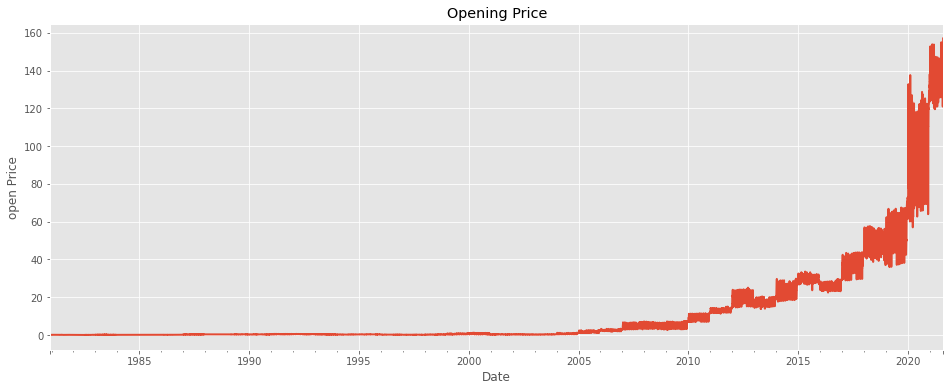

In [11]:
df['Open'].plot(figsize=(16,6))
plt.ylabel('open Price')
plt.title('Opening Price')

Text(0.5, 1.0, 'High Price')

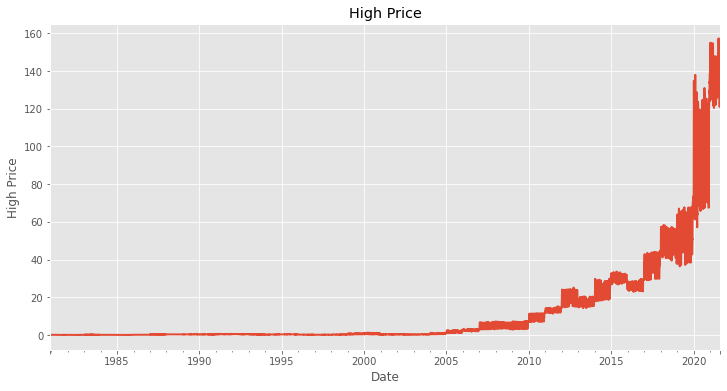

In [12]:
df['High'].plot(figsize=(12,6))
plt.ylabel('High Price')
plt.title('High Price')

Text(0.5, 1.0, 'Low Price')

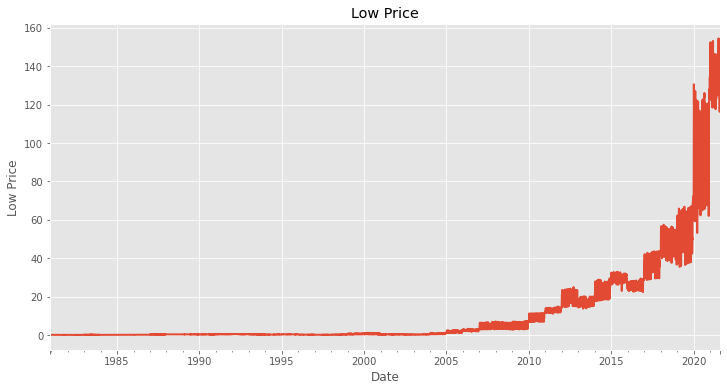

In [13]:
df['Low'].plot(figsize=(12,6))
plt.ylabel('Low Price')
plt.title('Low Price')

Text(0.5, 1.0, 'Closing Price')

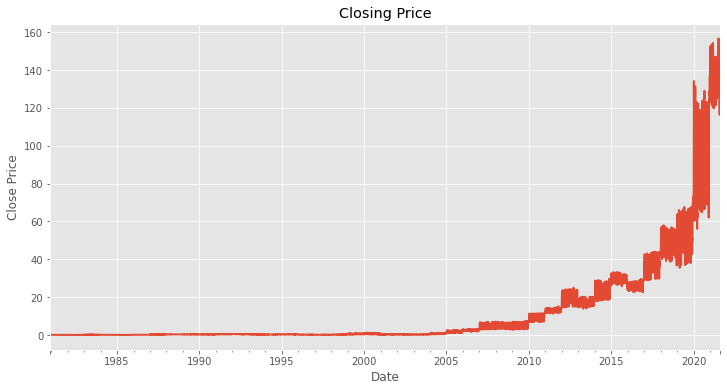

In [14]:
df['Close'].plot(figsize=(12,6))
plt.ylabel('Close Price')
plt.title('Closing Price')

Text(0.5, 1.0, 'Adjusted Closing Price')

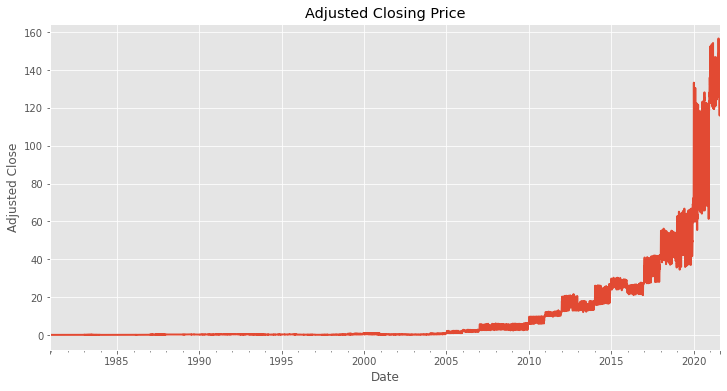

In [15]:
df['Adj Close'].plot(figsize=(12,6))
plt.ylabel('Adjusted Close')
plt.title('Adjusted Closing Price')

Text(0.5, 1.0, 'Volume Price')

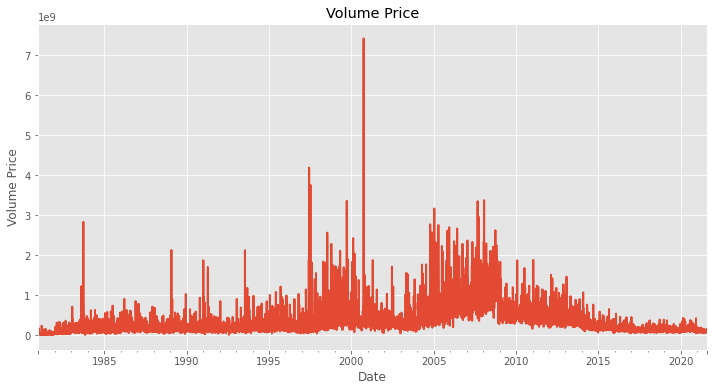

In [16]:
df['Volume'].plot(figsize=(12,6))
plt.ylabel('Volume Price')
plt.title('Volume Price')

In [17]:
df['Total Pov'] = df.sum(axis=1)

Text(0.5, 1.0, 'Total Portfolio Value')

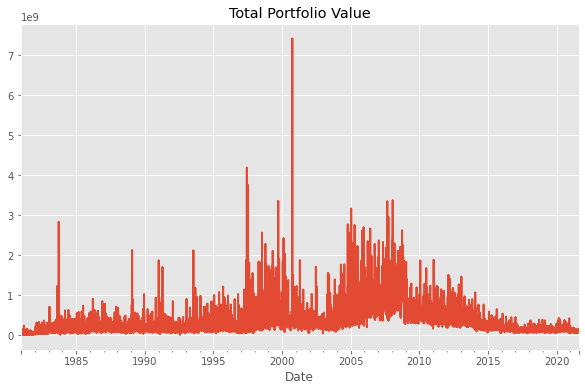

In [18]:
df['Total Pov'].plot(figsize=(10,6))
plt.title('Total Portfolio Value')

In [19]:
df['Daily Return'] = df['Total Pov'].pct_change(1)

In [20]:
df['Daily Return'].mean()

4347.119165738744

<AxesSubplot:ylabel='Density'>

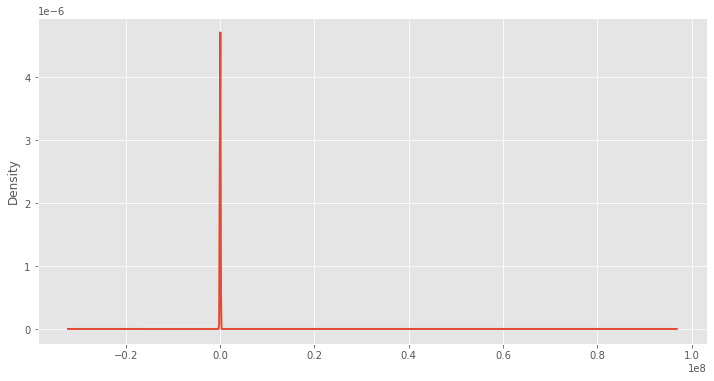

In [21]:
df['Daily Return'].plot(kind='kde', figsize=(12,6))

In [22]:
SR = df['Daily Return'].mean()/df['Daily Return'].std()
SR

0.008206384640422608

<AxesSubplot:xlabel='Date'>

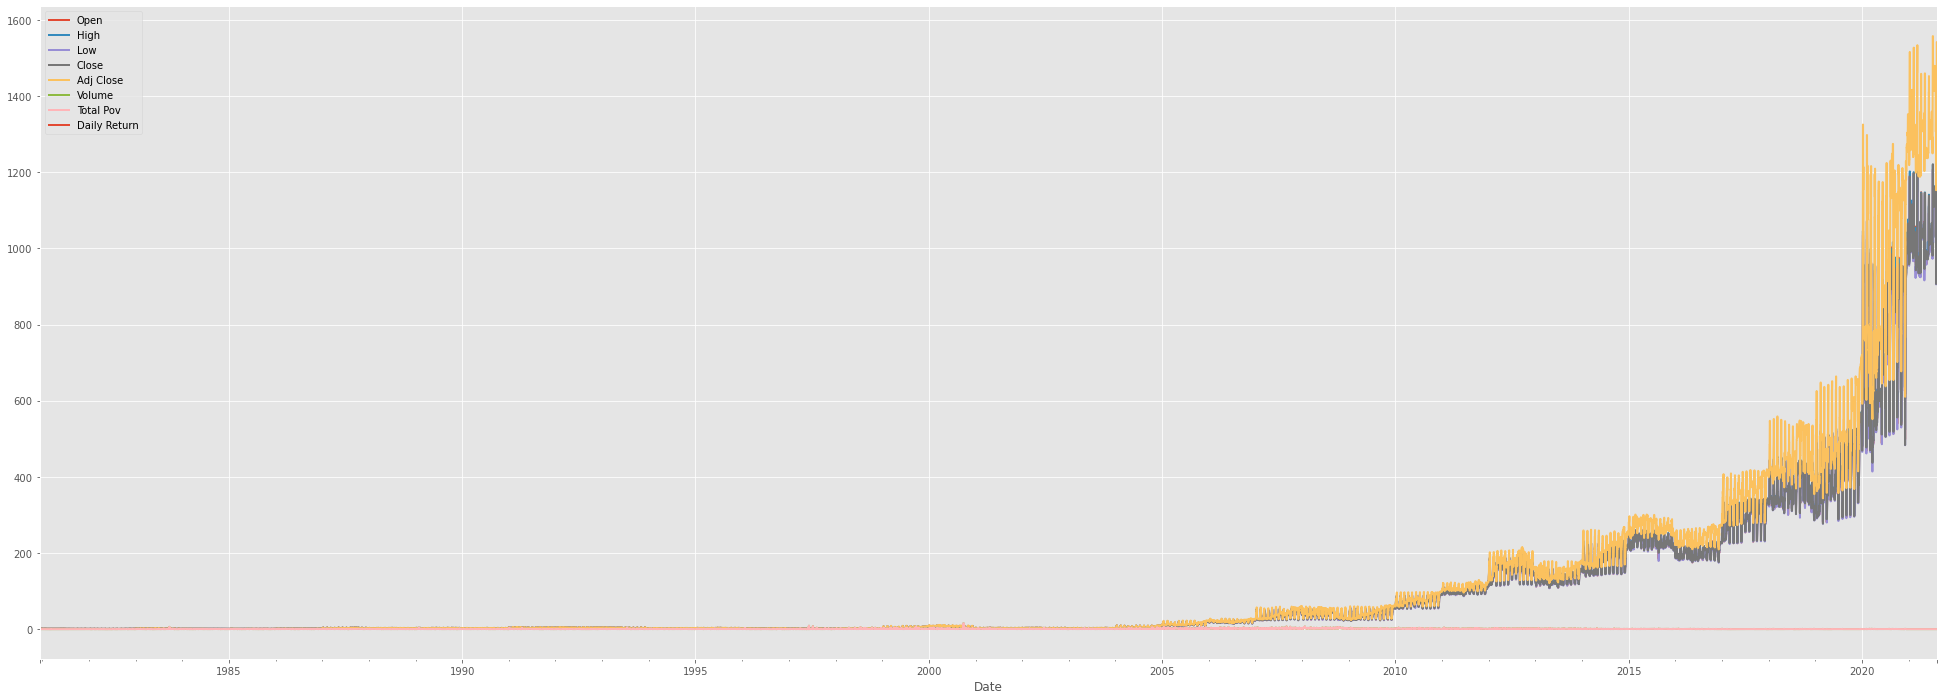

In [23]:
all_plt = df/df.iloc[0]
all_plt.plot(figsize=(34,12))

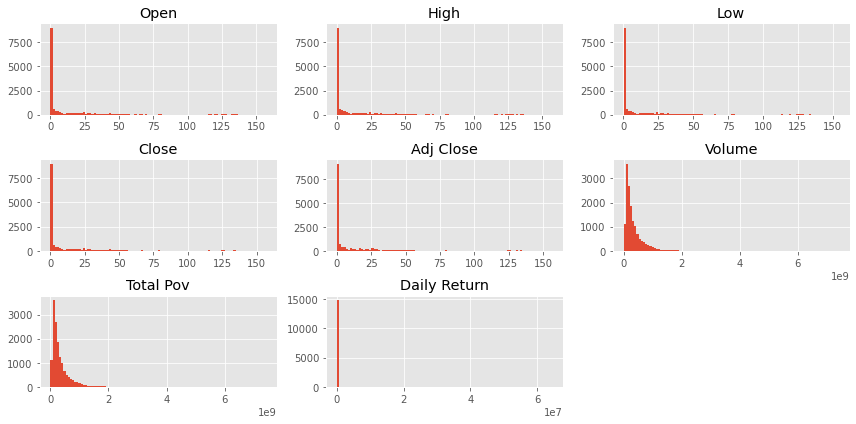

In [24]:
#3. histograms
df.hist(bins=100, figsize=(12,6));
plt.tight_layout()

In [26]:
df.resample(rule='A').mean()

,Open,High,Low,Close,Adj Close,Volume,Total Pov,Daily Return
Date,,,,,,,,
1980-12-31,0.137891,0.138281,0.137723,0.137723,0.107948,1.006622e+08,1.006622e+08,-0.081828
1981-12-31,0.108838,0.109219,0.108496,0.108496,0.085040,3.259519e+07,3.259519e+07,176856.357494
1982-12-31,0.085846,0.087023,0.084971,0.085794,0.067246,8.140344e+07,8.140344e+07,0.181868
1983-12-31,0.167151,0.170721,0.163135,0.166877,0.130800,1.757448e+08,1.757448e+08,0.589149
1984-12-31,0.119749,0.122085,0.117477,0.119604,0.093747,1.642560e+08,1.642560e+08,0.204819
1985-12-31,0.091102,0.092035,0.090013,0.090278,0.070761,1.727671e+08,1.727671e+08,0.215099
1986-12-31,0.144797,0.147146,0.142322,0.145011,0.113661,2.078382e+08,2.078382e+08,0.157084
1987-12-31,0.347248,0.355195,0.338535,0.346659,0.272244,2.315341e+08,2.315341e+08,0.106530
1988-12-31,0.370283,0.375985,0.364199,0.370216,0.292789,1.609477e+08,1.609477e+08,0.151530


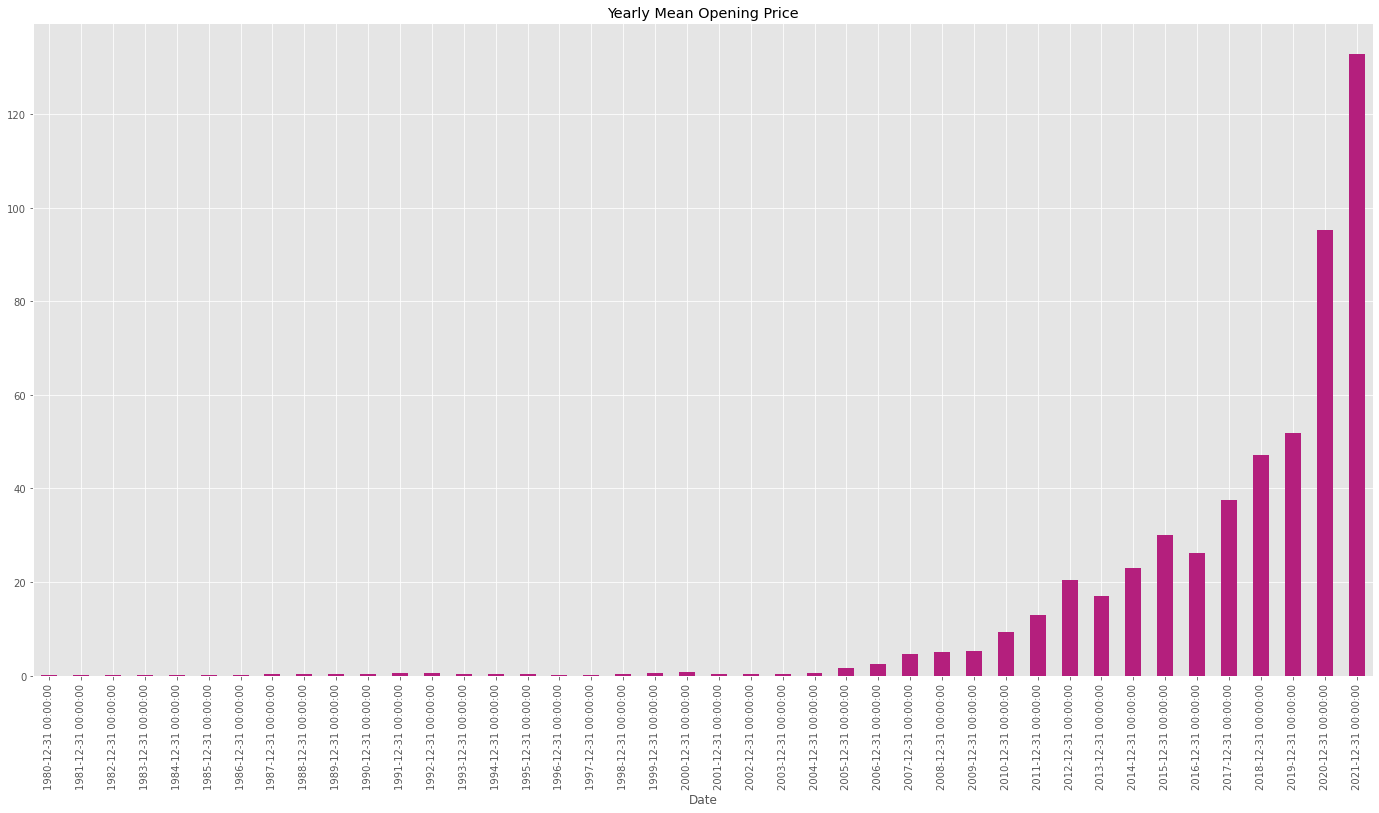

In [19]:
df['Open'].resample(rule='A').mean().plot.bar(title='Yearly Mean Opening Price', color=['#b41f7d'], figsize=(24,12));

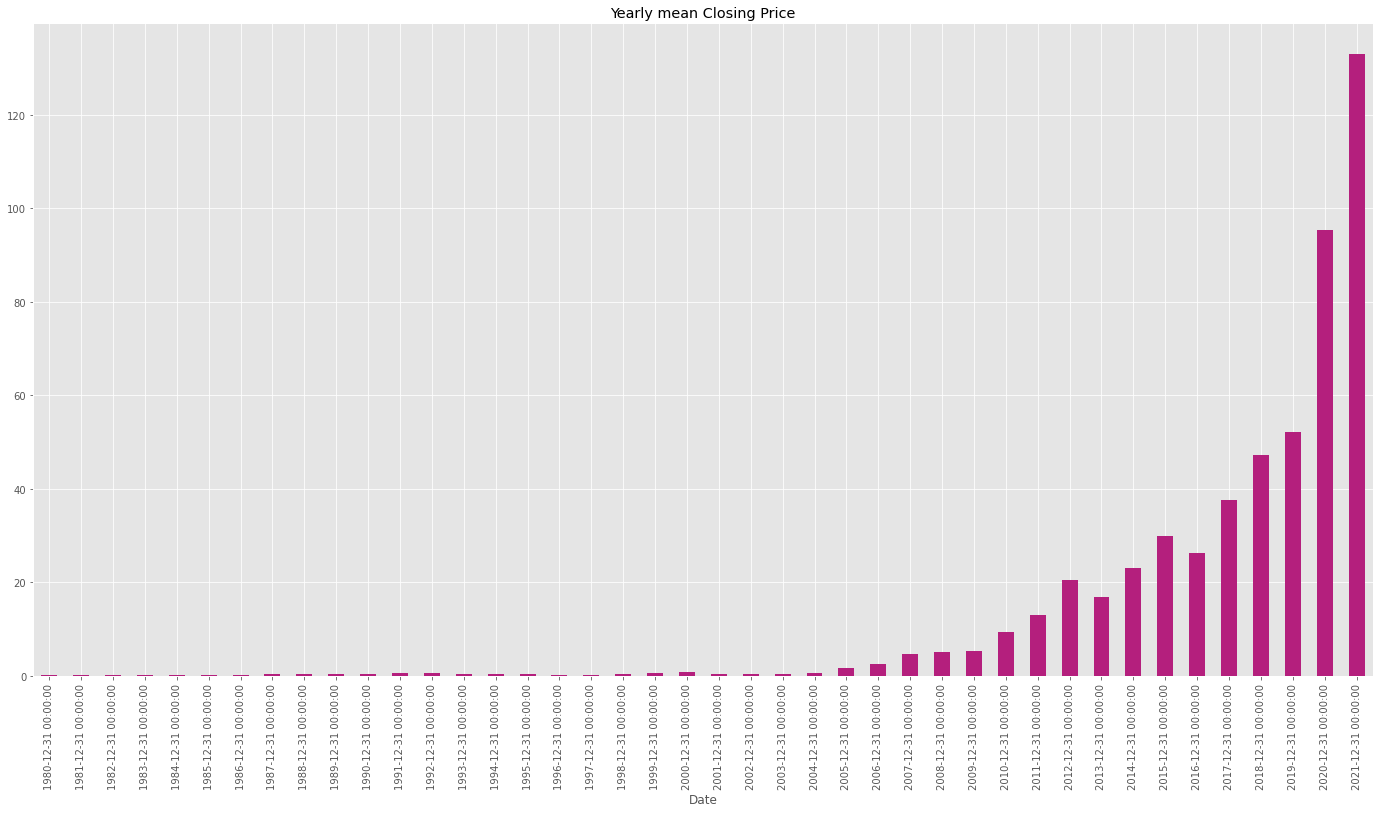

In [27]:
df['Close'].resample(rule='A').mean().plot.bar(title='Yearly mean Closing Price', color=['#b41f7d'],  figsize=(24,12));

In [28]:
df['6-month-SMA']  = df['Open'].rolling(window=6).mean()
df['12-month-SMA'] = df['Open'].rolling(window=12).mean()
df['2-month-SMA']  = df['Open'].rolling(window=2).mean()

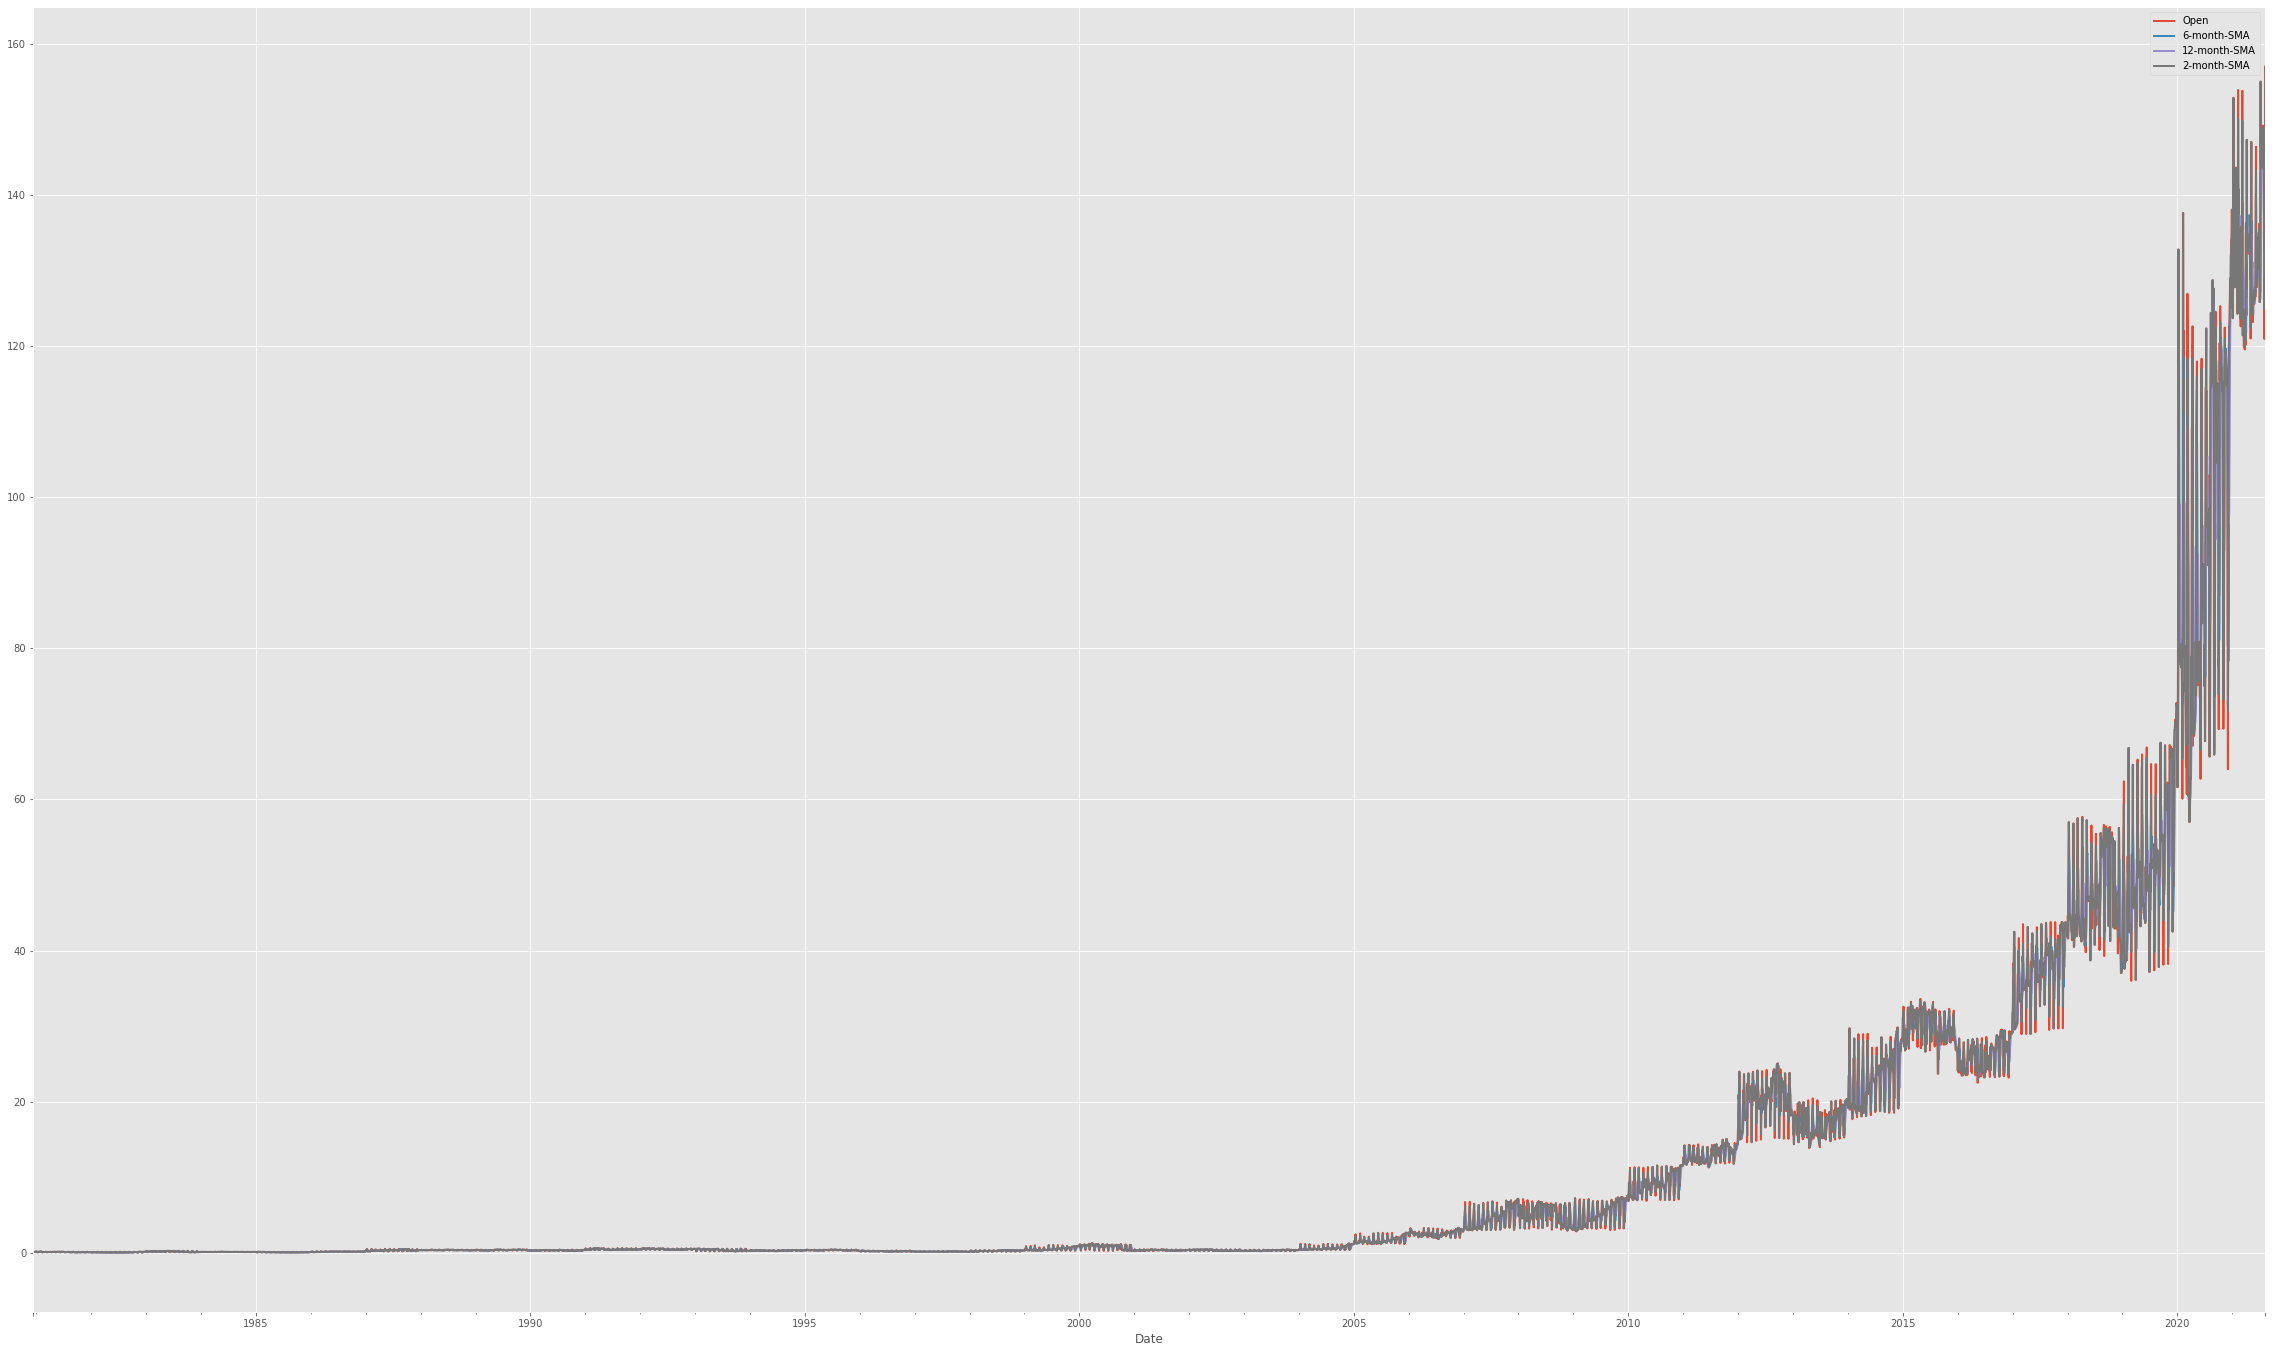

In [29]:
df[['Open', '6-month-SMA', '12-month-SMA', '2-month-SMA']].plot(figsize=(40,24));

<AxesSubplot:xlabel='Date'>

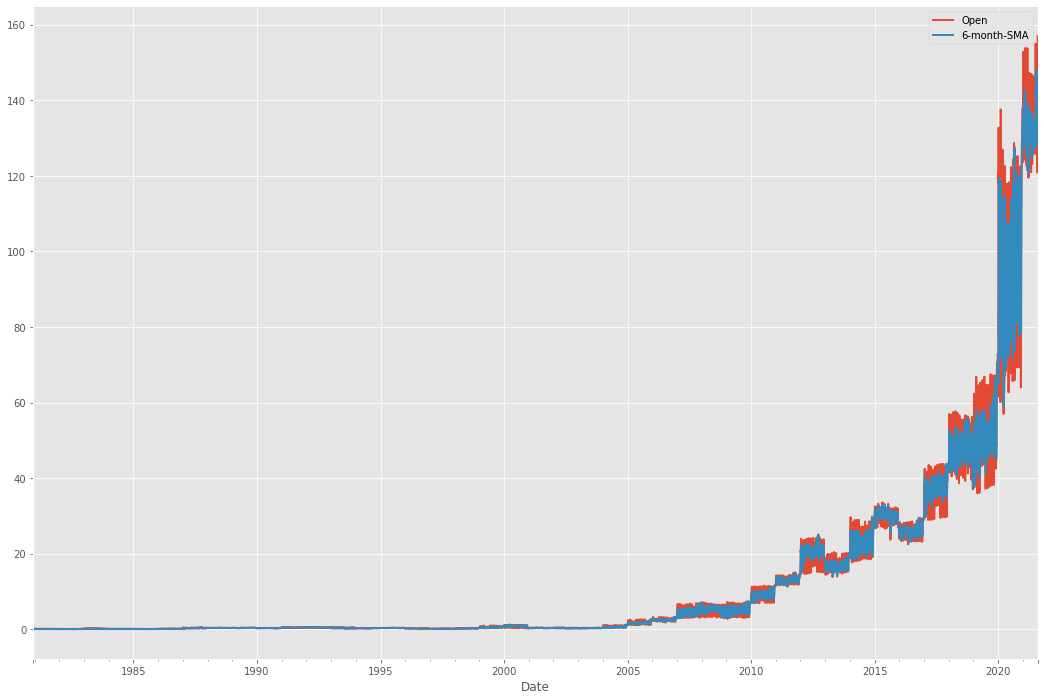

In [30]:
df[['Open','6-month-SMA']].plot(figsize=(18,12))

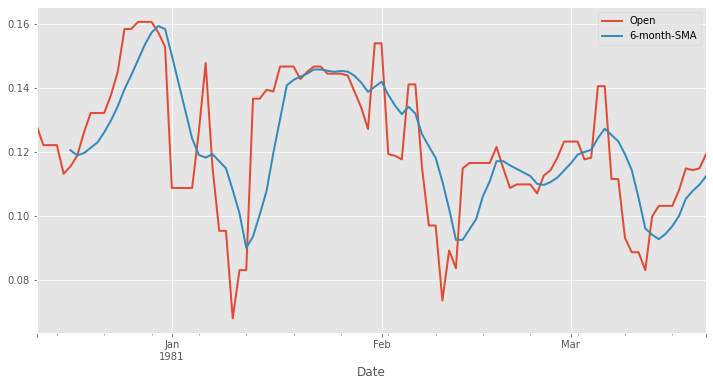

In [31]:
df[['Open', '6-month-SMA']].iloc[:100].plot(figsize=(12,6)).autoscale(axis='x', tight=True);

In [32]:
df['EWM-A12'] = df['Open'].ewm(span=14, adjust=True).mean()

In [33]:
span = 8
alpha = 2/(span+1)

In [34]:
df['EWM-A12'] = df['Open'].ewm(alpha=alpha, adjust= False).mean()

In [35]:
model = SimpleExpSmoothing(df['Open'])

In [36]:
fitted_model = model.fit(smoothing_level = alpha, optimized = False)

In [37]:
#df[['Open', 'EWM-A12']].plot(figsize=(24,12));
fitted_model.fittedvalues

Date
1980-12-12      0.128348
1980-12-13      0.128348
1980-12-14      0.126984
1980-12-15      0.125923
1980-12-16      0.125098
                 ...    
2021-08-05    133.999484
2021-08-06    132.355154
2021-08-07    131.076230
2021-08-08    133.410402
2021-08-09    138.648089
Freq: D, Length: 14851, dtype: float64

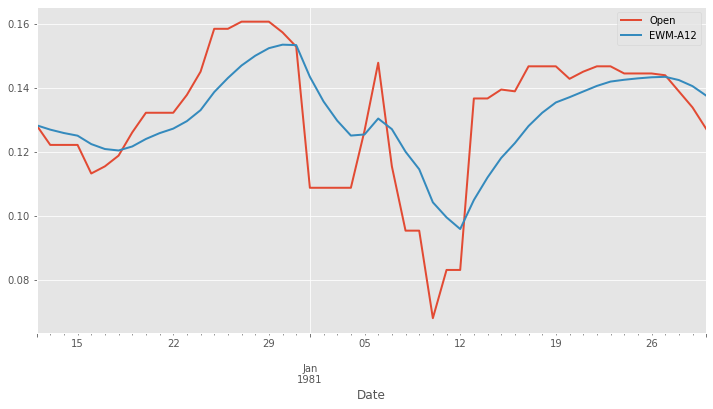

In [38]:
df[['Open','EWM-A12']].iloc[:50].plot(figsize=(12,6)).autoscale(axis='x', tight=True);

In [39]:
fitted_model.fittedvalues.shift(-1)

Date
1980-12-12      0.128348
1980-12-13      0.126984
1980-12-14      0.125923
1980-12-15      0.125098
1980-12-16      0.122472
                 ...    
2021-08-05    132.355154
2021-08-06    131.076230
2021-08-07    133.410402
2021-08-08    138.648089
2021-08-09           NaN
Freq: D, Length: 14851, dtype: float64

In [40]:
df['SES12'] = fitted_model.fittedvalues.shift(-1)

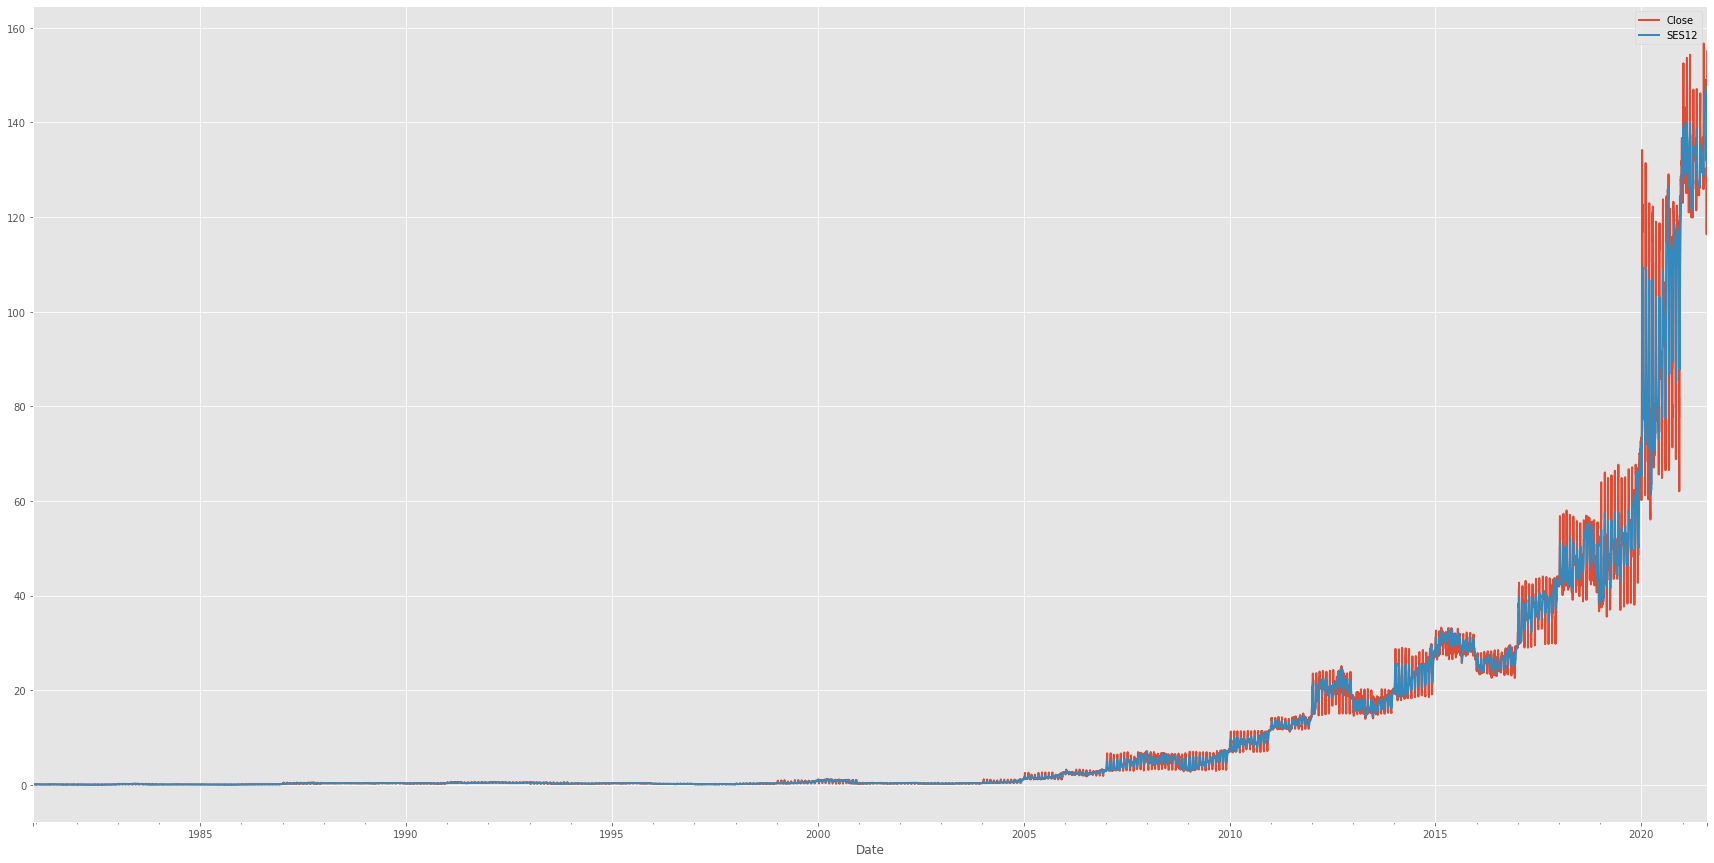

In [41]:
df[['Close','SES12']].plot(figsize=(30,15)).autoscale(axis='x', tight=True)

In [42]:
df['DESadd12'] = ExponentialSmoothing(df['Open'], trend='add').fit().fittedvalues.shift(-1)

In [43]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,Total Pov,Daily Return,6-month-SMA,12-month-SMA,2-month-SMA,EWM-A12,SES12,DESadd12
Date,,,,,,,,,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100600,469033600.0,4.690336e+08,NaN,NaN,NaN,NaN,0.128348,0.128348,0.137212
1980-12-13,0.122210,0.122210,0.121652,0.121652,0.095352,175884800.0,1.758848e+08,-0.625006,NaN,NaN,0.125279,0.126984,0.126984,0.131255
1980-12-14,0.122210,0.122210,0.121652,0.121652,0.095352,175884800.0,1.758848e+08,0.000000,NaN,NaN,0.122210,0.125923,0.125923,0.131084
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095352,175884800.0,1.758848e+08,0.000000,NaN,NaN,0.122210,0.125098,0.125098,0.131078
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088353,105728000.0,1.057280e+08,-0.398879,NaN,NaN,0.117746,0.122472,0.122472,0.122403


<AxesSubplot:xlabel='Date'>

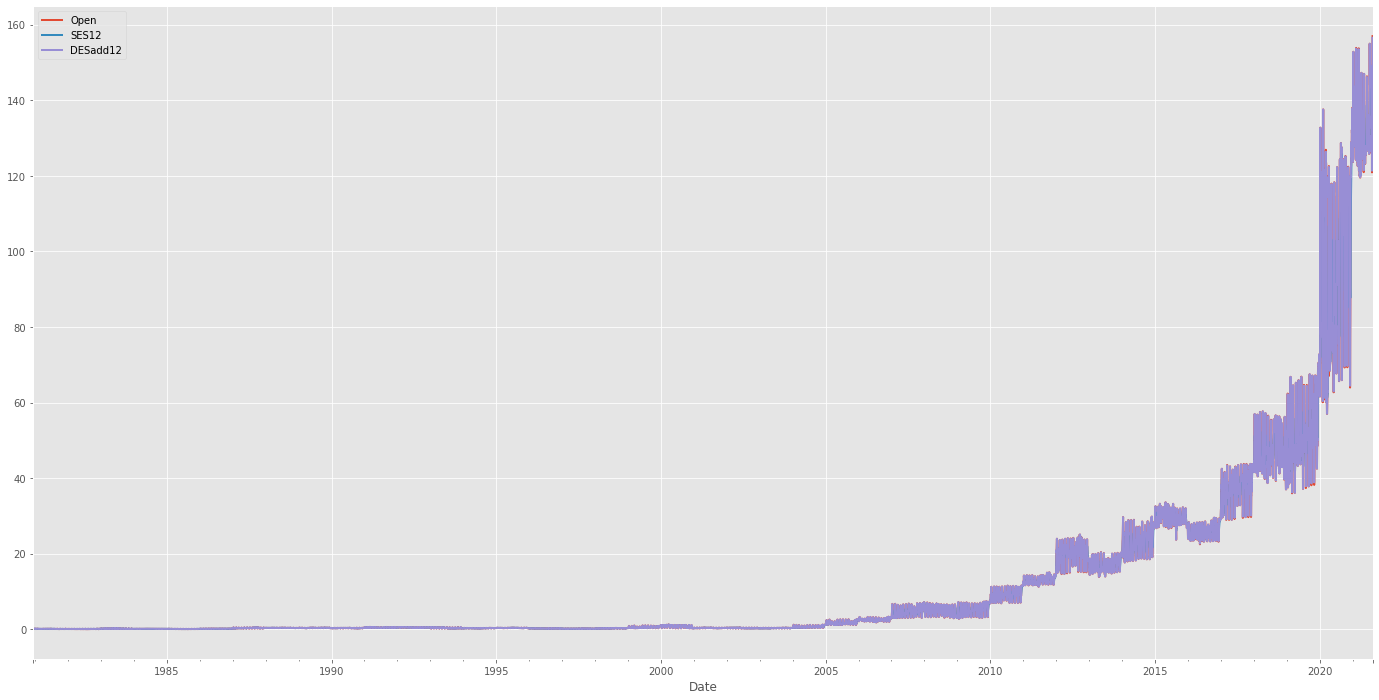

In [46]:
df[['Open', 'SES12', 'DESadd12']].plot(figsize=(24,12))

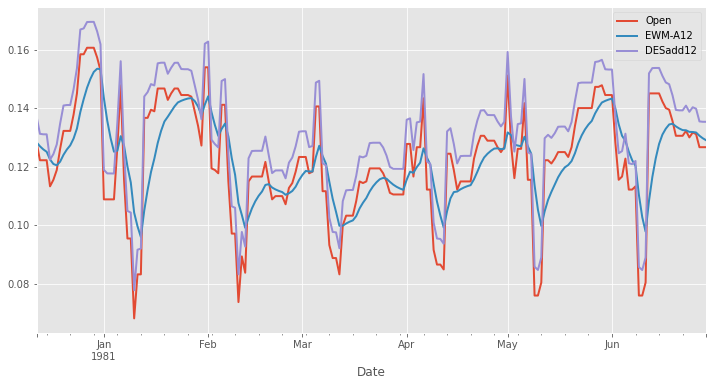

In [47]:
df[['Open', 'EWM-A12', 'DESadd12']].iloc[:200].plot(figsize=(12,6)).autoscale(axis='x', tight = True);

In [48]:
df['DESmul-12'] = ExponentialSmoothing(df['Open'], trend='mul').fit().fittedvalues.shift(-1)
df.head()

,Open,High,Low,Close,Adj Close,Volume,Total Pov,Daily Return,6-month-SMA,12-month-SMA,2-month-SMA,EWM-A12,SES12,DESadd12,DESmul-12
Date,,,,,,,,,,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100600,469033600.0,4.690336e+08,NaN,NaN,NaN,NaN,0.128348,0.128348,0.137212,0.125712
1980-12-13,0.122210,0.122210,0.121652,0.121652,0.095352,175884800.0,1.758848e+08,-0.625006,NaN,NaN,0.125279,0.126984,0.126984,0.131255,0.119662
1980-12-14,0.122210,0.122210,0.121652,0.121652,0.095352,175884800.0,1.758848e+08,0.000000,NaN,NaN,0.122210,0.125923,0.125923,0.131084,0.119464
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095352,175884800.0,1.758848e+08,0.000000,NaN,NaN,0.122210,0.125098,0.125098,0.131078,0.119467
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088353,105728000.0,1.057280e+08,-0.398879,NaN,NaN,0.117746,0.122472,0.122472,0.122403,0.111017


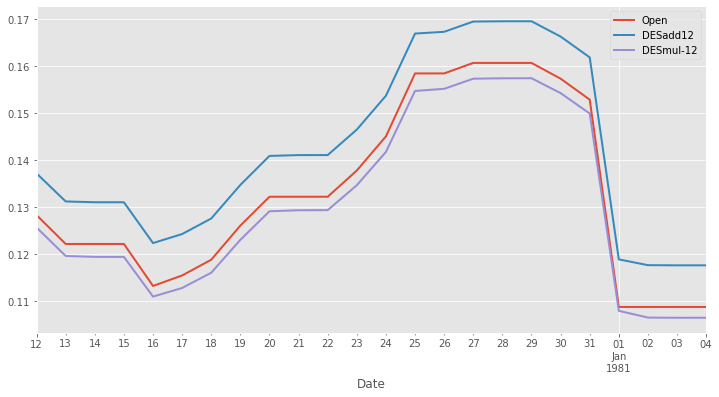

In [49]:
df[['Open','DESadd12','DESmul-12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x', tight = True);

In [50]:
df['TESadd12'] = ExponentialSmoothing(df['Open'], trend = 'add', seasonal = 'add', seasonal_periods =12).fit().fittedvalues

In [51]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Total Pov',
       'Daily Return', '6-month-SMA', '12-month-SMA', '2-month-SMA', 'EWM-A12',
       'SES12', 'DESadd12', 'DESmul-12', 'TESadd12'],
      dtype='object')

In [52]:
df['TESmul-12'] = ExponentialSmoothing(df['Open'], trend='mul', seasonal='mul', seasonal_periods=12).fit().fittedvalues
df.head()

,Open,High,Low,Close,Adj Close,Volume,Total Pov,Daily Return,6-month-SMA,12-month-SMA,2-month-SMA,EWM-A12,SES12,DESadd12,DESmul-12,TESadd12,TESmul-12
Date,,,,,,,,,,,,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100600,469033600.0,4.690336e+08,NaN,NaN,NaN,NaN,0.128348,0.128348,0.137212,0.125712,0.141099,0.515368
1980-12-13,0.122210,0.122210,0.121652,0.121652,0.095352,175884800.0,1.758848e+08,-0.625006,NaN,NaN,0.125279,0.126984,0.126984,0.131255,0.119662,0.139234,0.157079
1980-12-14,0.122210,0.122210,0.121652,0.121652,0.095352,175884800.0,1.758848e+08,0.000000,NaN,NaN,0.122210,0.125923,0.125923,0.131084,0.119464,0.120947,0.131667
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095352,175884800.0,1.758848e+08,0.000000,NaN,NaN,0.122210,0.125098,0.125098,0.131078,0.119467,0.118979,0.127674
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088353,105728000.0,1.057280e+08,-0.398879,NaN,NaN,0.117746,0.122472,0.122472,0.122403,0.111017,0.125995,0.127315


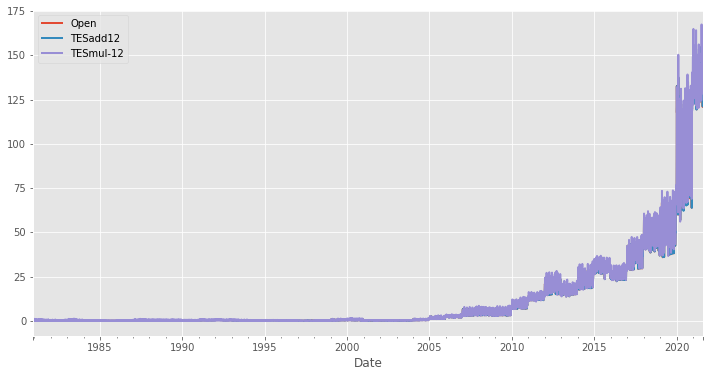

In [53]:
df[['Open', 'TESadd12', 'TESmul-12']].plot(figsize=(12,6)).autoscale(axis='x', tight=True);

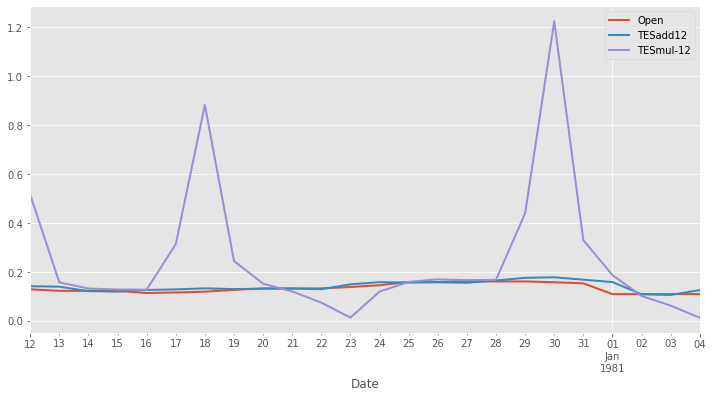

In [54]:
df[['Open', 'TESadd12', 'TESmul-12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x', tight=True);

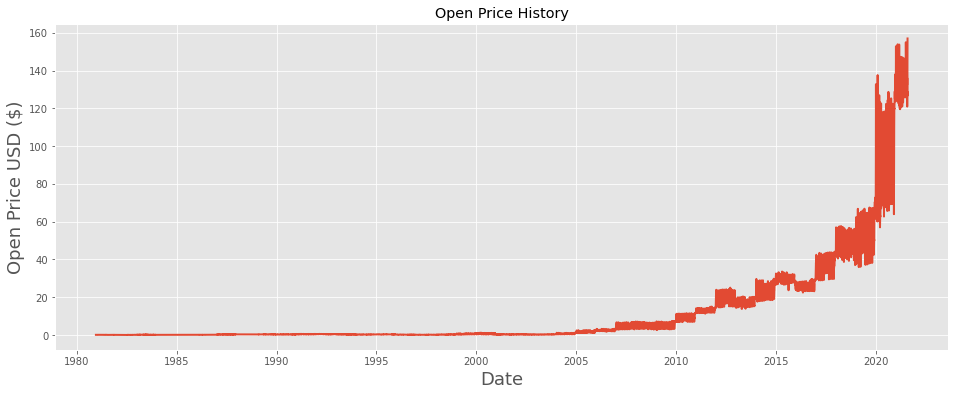

In [55]:
plt.figure(figsize=(16,6))
plt.title('Open Price History')
plt.plot(df['Open'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD ($)', fontsize=18)
plt.show()

# LSTM MODEL

In [56]:
#determining train set length
data = df.filter(['Open'])
dataset = data.values
training_data_len = int(np.ceil (len(dataset) * .80))
training_data_len

11881

In [57]:
#normalizing scale 0-1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data
scaled_data.shape

(14851, 1)

In [58]:
train_data = scaled_data[0:int(training_data_len), :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.00050139, 0.00046228, 0.00046228, 0.00046228, 0.00040538,
       0.0004196 , 0.00044094, 0.00048717, 0.00052628, 0.00052628,
       0.00052628, 0.00056184, 0.00060807, 0.00069341, 0.00069341,
       0.00070763, 0.00070763, 0.00070763, 0.0006863 , 0.00065785,
       0.00037693, 0.00037693, 0.00037693, 0.00037693, 0.00049072,
       0.00062584, 0.0004196 , 0.00029159, 0.00029159, 0.00011735,
       0.00021336, 0.00021336, 0.00055473, 0.00055473, 0.00057251,
       0.00056895, 0.00061873, 0.00061873, 0.00061873, 0.00059384,
       0.00060807, 0.00061873, 0.00061873, 0.00060451, 0.00060451,
       0.00060451, 0.00060095, 0.00056895, 0.00053695, 0.00049428,
       0.00066496, 0.00066496, 0.0004445 , 0.00044094, 0.00043383,
       0.00058318, 0.00058318, 0.00041604, 0.00030226, 0.00030226])]
[0.0001529086177738324]

[array([0.00050139, 0.00046228, 0.00046228, 0.00046228, 0.00040538,
       0.0004196 , 0.00044094, 0.00048717, 0.00052628, 0.00052628,
       0.00052628, 0.00056184, 0.

In [92]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(16))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 60, 64)            16896     
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_12 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 17        
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [61]:
callbacks = [EarlyStopping(patience=3, monitor='loss', mode='min'),ReduceLROnPlateau(patience=2, verbose=1)]

In [62]:
history = model.fit(x_train, y_train, epochs=20, batch_size=128, callbacks=[callbacks],)

Epoch 1/20
93/93 [==============================] - 36s 386ms/step - loss: 9.7128e-05
Epoch 2/20
93/93 [==============================] - 36s 391ms/step - loss: 1.7328e-05
Epoch 3/20
93/93 [==============================] - 38s 414ms/step - loss: 1.8844e-05
Epoch 4/20
93/93 [==============================] - 36s 391ms/step - loss: 1.8232e-05
Epoch 5/20
93/93 [==============================] - 38s 405ms/step - loss: 1.6077e-05
Epoch 6/20
93/93 [==============================] - 37s 401ms/step - loss: 1.5915e-05
Epoch 7/20
93/93 [==============================] - 36s 388ms/step - loss: 1.6400e-05
Epoch 8/20
93/93 [==============================] - 36s 388ms/step - loss: 1.5300e-05
Epoch 9/20
93/93 [==============================] - 36s 387ms/step - loss: 1.5101e-05
Epoch 10/20
93/93 [==============================] - 36s 392ms/step - loss: 1.4175e-05
Epoch 11/20
93/93 [==============================] - 36s 389ms/step - loss: 1.3602e-05
Epoch 12/20
93/93 [==============================] -

In [65]:
test_data = scaled_data[training_data_len - 60: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60: i, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

preds = model.predict(x_test)
preds = scaler.inverse_transform(preds)

rmse = np.sqrt(np.mean(((preds - y_test)**2)))
print ('Root Mean Squared Error',rmse)
print ('Mean Absolute Error',mean_absolute_error(y_test, preds))

Root Mean Squared Error 6.215555425443779
Mean Absolute Error 3.3292382722700022


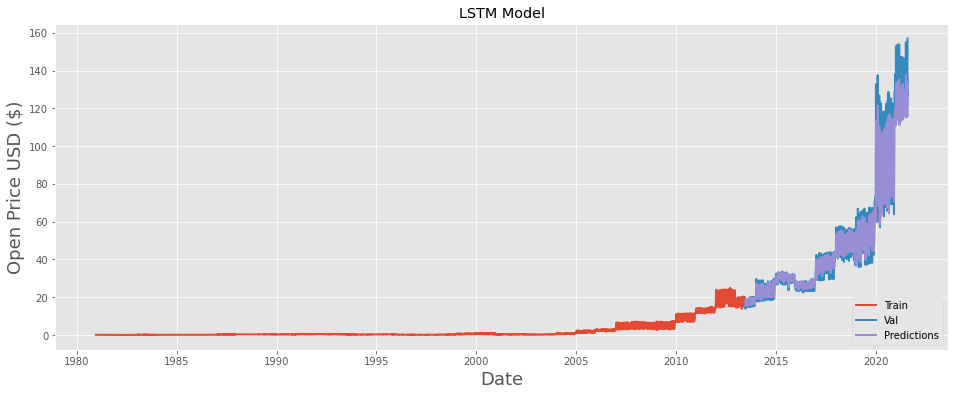

In [104]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = preds

plt.figure(figsize=(16,6))
plt.title('LSTM Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD ($)', fontsize=18)
plt.plot(train['Open'])
plt.plot(valid[['Open', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

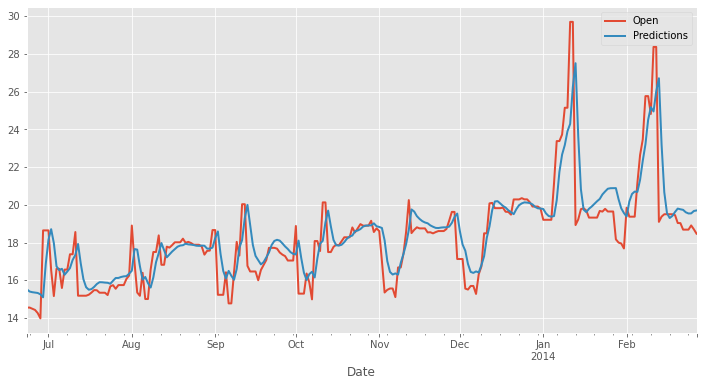

In [105]:
valid[['Open', 'Predictions']].iloc[:250].plot(figsize=(12,6)).autoscale(axis='x', tight = True);

# Gated Recurrent Unit (GRU)

In [ ]:
model_gru = Sequential()
model_gru.add(GRU(64,return_sequences=True,))

In [94]:
model2 = Sequential()
model2.add(GRU(64, return_sequences=True, input_shape=(x_train.shape[1],1)))
model2.add(GRU(32, return_sequences=False))
model2.add(Dense(16))
model2.add(Dropout(0.2))
model2.add(Dense(1))
model2.compile(optimizer='rmsprop', loss='mean_squared_error',metrics='mean_squared_error')
model2.summary()

#model2.compile(optimizer='rmsprop',loss='mean_squared_error',metrics=['mae','mse'])



Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_28 (GRU)                 (None, 60, 64)            12864     
_________________________________________________________________
gru_29 (GRU)                 (None, 32)                9408      
_________________________________________________________________
dense_16 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 17        
Total params: 22,817
Trainable params: 22,817
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callbacks = [EarlyStopping(patience=3, monitor='loss', mode='min'),
            ReduceLROnPlateau(patience=2, verbose=1)]

In [112]:
model2.fit(x_train, y_train, epochs=20, batch_size=128)

Epoch 1/20
93/93 [==============================] - 37s 400ms/step - loss: 7.7344e-05 - mean_squared_error: 7.7344e-05
Epoch 2/20
93/93 [==============================] - 38s 408ms/step - loss: 7.0069e-05 - mean_squared_error: 7.0069e-05
Epoch 3/20
93/93 [==============================] - 35s 382ms/step - loss: 6.2972e-05 - mean_squared_error: 6.2972e-05
Epoch 4/20
93/93 [==============================] - 29s 308ms/step - loss: 5.9535e-05 - mean_squared_error: 5.9535e-05
Epoch 5/20
93/93 [==============================] - 28s 304ms/step - loss: 5.3847e-05 - mean_squared_error: 5.3847e-05
Epoch 6/20
93/93 [==============================] - 28s 306ms/step - loss: 5.5040e-05 - mean_squared_error: 5.5040e-05
Epoch 7/20
93/93 [==============================] - 29s 309ms/step - loss: 4.7812e-05 - mean_squared_error: 4.7812e-05
Epoch 8/20
93/93 [==============================] - 29s 307ms/step - loss: 5.1126e-05 - mean_squared_error: 5.1126e-05
Epoch 9/20
93/93 [==============================

In [108]:
preds_gru = model2.predict(x_test)
preds_gru = scaler.inverse_transform(preds_gru)

rmse = np.sqrt(np.mean(((preds_gru - y_test)**2)))
print ('Root Mean Squared Error',rmse)
print ('Mean Absolute Error',mean_absolute_error(y_test, preds_gru))

Root Mean Squared Error 7.2926838837705805
Mean Absolute Error 4.367821686288134


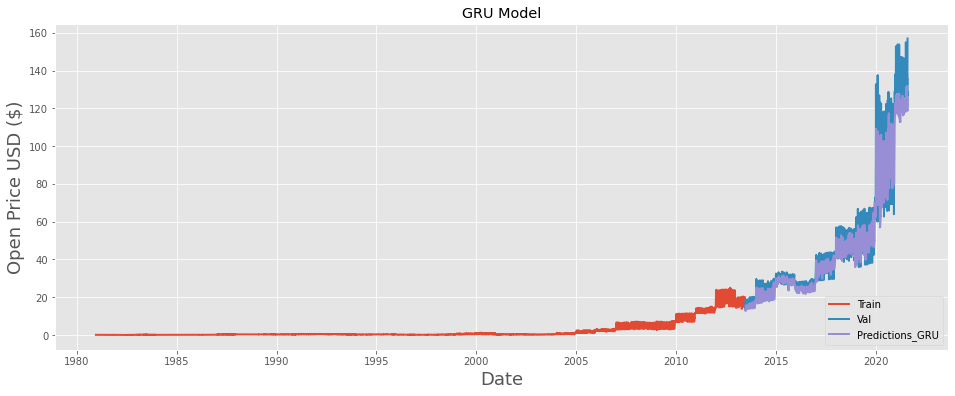

In [110]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions_GRU'] = preds_gru

plt.figure(figsize=(16,6))
plt.title('GRU Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD ($)', fontsize=18)
plt.plot(train['Open'])
plt.plot(valid[['Open', 'Predictions_GRU']])
plt.legend(['Train', 'Val', 'Predictions_GRU'], loc='lower right')
plt.show()

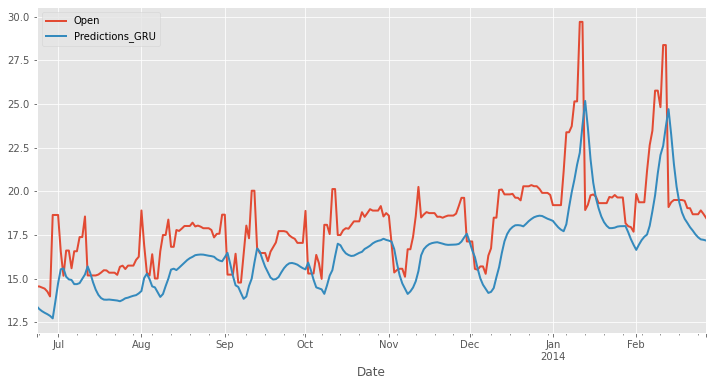

In [111]:
valid[['Open', 'Predictions_GRU']].iloc[:250].plot(figsize=(12,6)).autoscale(axis='x', tight = True);